In [1]:
import random
import numpy as np
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt

### Flemin's function of second order model in python

In [2]:
def compute_meta_conf(xp, a, sigma_act, sigma_conf, rho):

    dhat = np.array([-1, 1])
    mu_x_xp_dhat = np.zeros((2, len(xp)))
    var_x_xp_dhat = np.zeros(len(xp))
    rho_vec = np.full(len(xp), rho)
    sigA_vec = np.full(len(xp), sigma_act)
    sigP_vec = np.full(len(xp), sigma_conf)
    
    Tol = 10e-4

    for dhati in range(2):
        dhat_vec = np.full(len(xp), dhat[dhati])
        
        mu_x_xp_dhat[dhati, :] = dhat_vec + (sigA_vec / sigP_vec) * rho_vec * (xp - dhat_vec)
        var_x_xp_dhat = (1 - rho_vec**2) * sigA_vec**2
        
        if a == 1:
            p_a_dhat_xp = 1 - norm.cdf(0, mu_x_xp_dhat[dhati, :], np.sqrt(var_x_xp_dhat))
        else:
            p_a_dhat_xp = norm.cdf(0, mu_x_xp_dhat[dhati, :], np.sqrt(var_x_xp_dhat))
        
        lik_d = norm.pdf(xp, dhat_vec, sigP_vec)
        
        if dhati == 0:
            p_a_dhat_xp_full = p_a_dhat_xp
            lik_d_full = lik_d
        else:
            p_a_dhat_xp_full = np.vstack((p_a_dhat_xp_full, p_a_dhat_xp))
            lik_d_full = np.vstack((lik_d_full, lik_d))
    
    # manage probability
    p_a_dhat_xp_full = np.clip(p_a_dhat_xp_full, Tol, None)
    lik_d_full = np.clip(lik_d_full, Tol, None)
    
    lik_d_full = lik_d_full / np.sum(lik_d_full, axis=0, keepdims=True)
    p_dhat_xp_a = p_a_dhat_xp_full * lik_d_full
    p_dhat_xp_a = p_dhat_xp_a / np.sum(p_dhat_xp_a, axis=0, keepdims=True)
    
    # Conf = p(a=d)
    if a == 1:
        conf = p_dhat_xp_a[1, :]
    else:
        conf = p_dhat_xp_a[0, :]
    
    return conf


### Simulation of N trials

In [3]:
# theta = [0, 0.032, 0.064, 0.128, 0.256, 0.512, 1]
# sigmaAct = 1
# sigmaConf = 1
# rho = 0.5
# bigSigma = np.array([[sigmaAct**2, rho * sigmaAct * sigmaConf], [rho * sigmaAct * sigmaConf, sigmaConf**2]])

# N = 2  # N trials

# xa = np.empty((len(theta), N))
# xp = np.empty((len(theta), N))
# d = np.empty((len(theta), N))
# a = np.empty((len(theta), N))
# secondOrder_mean_cor = np.empty((len(theta), N))

# for s in range(len(theta)):
#     for i in range(N):
#         d[s, i] = 1 if np.random.rand() > 0.5 else -1
        
#         r = multivariate_normal.rvs(mean=[d[s, i] * theta[s], d[s, i] * theta[s]], cov=bigSigma)
#         xa[s, i] = r[0]
#         xp[s, i] = r[1]
        
#         if xa[s, i] > 0:
#             a[s, i] = 1
#             flip_a = 1
#         else:
#             a[s, i] = -1
#             flip_a = 0
        
#         secondOrder_mean_cor[s, i] = compute_meta_conf(np.array([xp[s, i]]), flip_a, sigmaAct, sigmaConf, rho)[0]

# print("(d):", d)
# print("(a):", a)
# print("Second Order Confidences:", secondOrder_mean_cor)
# print('xa ',xa)
# print('xp ', xp)

### Try to simulate N consecutive trials. Without parameter updating over the time

In [4]:
theta = [0/6, 1/6, 2/6, 3/6, 4/6, 5/6, 6/6] # I changed a little, because is very easy so far 
sigmaAct = 2.5  # 1
sigmaConf = 2.5 # 1
rho = 0.5 # 0.5
bigSigma = np.array([[sigmaAct**2, rho * sigmaAct * sigmaConf], [rho * sigmaAct * sigmaConf, sigmaConf**2]])

N = 1000  # N trials

xa = np.empty(N)
xp = np.empty(N)
d = np.empty(N)
a = np.empty(N)
secondOrder_mean_cor = np.empty(N)

for i in range(N):
    current_theta = random.choice(theta)
    
    d[i] = 1 if np.random.rand() > 0.5 else -1
    
    r = multivariate_normal.rvs(mean=[d[i] * current_theta, d[i] * current_theta], cov=bigSigma)
    
    xa[i] = r[0]
    xp[i] = r[1]
    
    if xa[i] > 0:
        a[i] = 1
        flip_a = 1
    else:
        a[i] = -1
        flip_a = 0
    
    secondOrder_mean_cor[i] = compute_meta_conf(np.array([xp[i]]), flip_a, sigmaAct, sigmaConf, rho)[0]

#print("(d):", d)
#print("(a):", a)
#print("Second Order Confidences:", secondOrder_mean_cor)
#print('xa ',xa)
#print('xp ', xp)
#print(np.count_nonzero(d == a))
#print(np.count_nonzero(d != a))


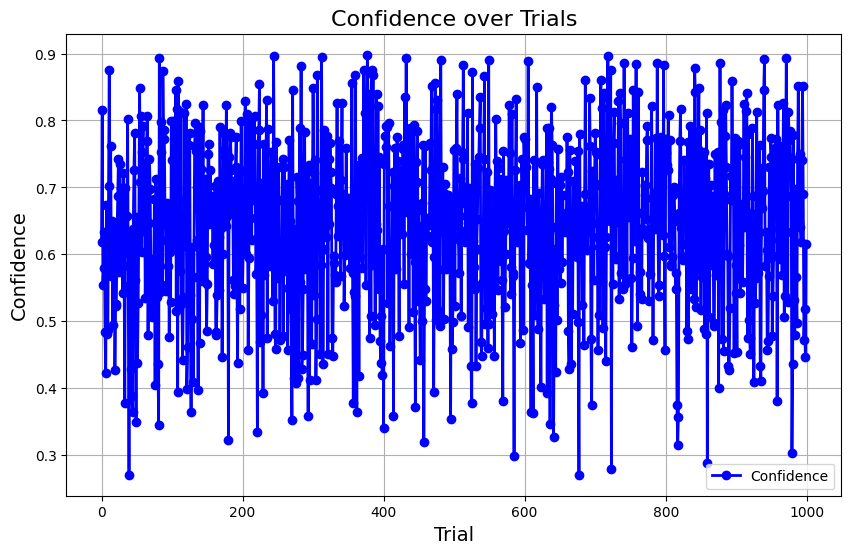

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(range(N), secondOrder_mean_cor, 'bo-', label='Confidence', linewidth=2)
plt.xlabel('Trial', fontsize=14)
plt.ylabel('Confidence', fontsize=14)
plt.title('Confidence over Trials', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

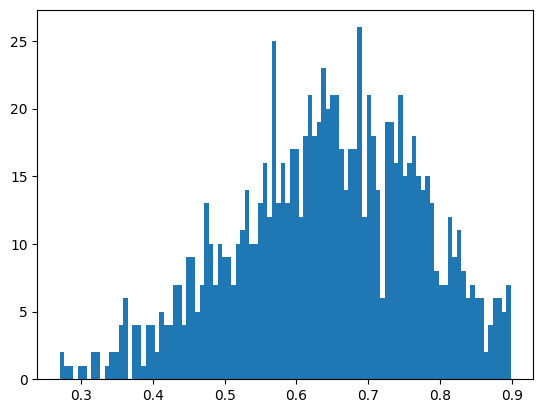

In [6]:
plt.hist(secondOrder_mean_cor, bins=100)
plt.show()

### Try Chatgpt function to plot the figure 3 of fleming paper

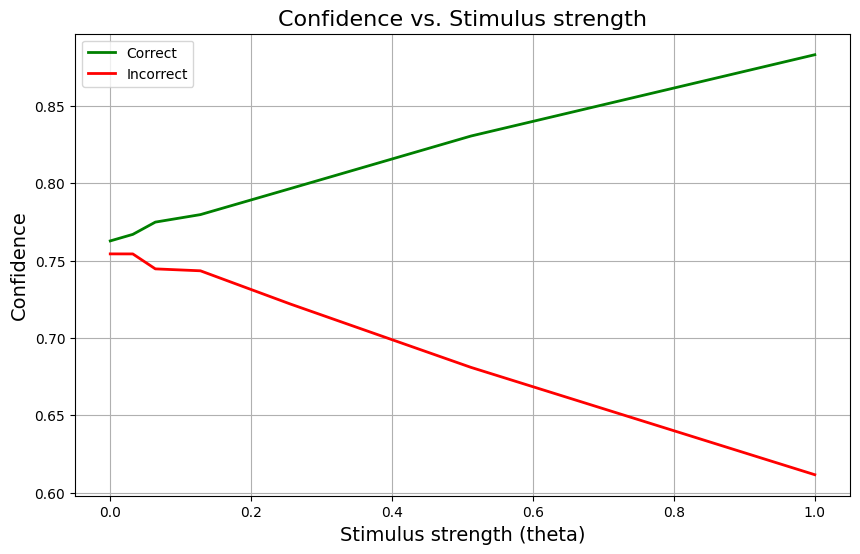

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm

def compute_meta_conf(xp, a, sigma_act, sigma_conf, rho):
    dhat = np.array([-1, 1])
    mu_x_xp_dhat = np.zeros((2, len(xp)))
    var_x_xp_dhat = np.zeros(len(xp))
    rho_vec = np.full(len(xp), rho)
    sigA_vec = np.full(len(xp), sigma_act)
    sigP_vec = np.full(len(xp), sigma_conf)
    
    Tol = 10e-4

    for dhati in range(2):
        dhat_vec = np.full(len(xp), dhat[dhati])
        
        mu_x_xp_dhat[dhati, :] = dhat_vec + (sigA_vec / sigP_vec) * rho_vec * (xp - dhat_vec)
        var_x_xp_dhat = (1 - rho_vec**2) * sigA_vec**2
        
        if a == 1:
            p_a_dhat_xp = 1 - norm.cdf(0, mu_x_xp_dhat[dhati, :], np.sqrt(var_x_xp_dhat))
        else:
            p_a_dhat_xp = norm.cdf(0, mu_x_xp_dhat[dhati, :], np.sqrt(var_x_xp_dhat))
        
        lik_d = norm.pdf(xp, dhat_vec, sigP_vec)
        
        if dhati == 0:
            p_a_dhat_xp_full = p_a_dhat_xp
            lik_d_full = lik_d
        else:
            p_a_dhat_xp_full = np.vstack((p_a_dhat_xp_full, p_a_dhat_xp))
            lik_d_full = np.vstack((lik_d_full, lik_d))
    
    # manage probability
    p_a_dhat_xp_full = np.clip(p_a_dhat_xp_full, Tol, None)
    lik_d_full = np.clip(lik_d_full, Tol, None)
    
    lik_d_full = lik_d_full / np.sum(lik_d_full, axis=0, keepdims=True)
    p_dhat_xp_a = p_a_dhat_xp_full * lik_d_full
    p_dhat_xp_a = p_dhat_xp_a / np.sum(p_dhat_xp_a, axis=0, keepdims=True)
    
    # Conf = p(a=d)
    if a == 1:
        conf = p_dhat_xp_a[1, :]
    else:
        conf = p_dhat_xp_a[0, :]
    
    return conf

theta = [0, 0.032, 0.064, 0.128, 0.256, 0.512, 1]
sigmaAct = 1
sigmaConf = 1
rho = 0.5
bigSigma = np.array([[sigmaAct**2, rho * sigmaAct * sigmaConf], [rho * sigmaAct * sigmaConf, sigmaConf**2]])

N = 10000  # N trials

xa = np.empty((len(theta), N))
xp = np.empty((len(theta), N))
d = np.empty((len(theta), N))
a = np.empty((len(theta), N))
secondOrder_mean_cor = np.empty((len(theta), N))

for s in range(len(theta)):
    for i in range(N):
        d[s, i] = 1 if np.random.rand() > 0.5 else -1
        
        r = multivariate_normal.rvs(mean=[d[s, i] * theta[s], d[s, i] * theta[s]], cov=bigSigma)
        xa[s, i] = r[0]
        xp[s, i] = r[1]
        
        if xa[s, i] > 0:
            a[s, i] = 1
            flip_a = 1
        else:
            a[s, i] = -1
            flip_a = 0
        
        secondOrder_mean_cor[s, i] = compute_meta_conf(np.array([xp[s, i]]), flip_a, sigmaAct, sigmaConf, rho)[0]

# Calcular la confianza promedio para respuestas correctas e incorrectas
conf_cor = []
conf_err = []

for s in range(len(theta)):
    correct = secondOrder_mean_cor[s, d[s] == a[s]]
    incorrect = secondOrder_mean_cor[s, d[s] != a[s]]
    
    conf_cor.append(np.mean(correct))
    conf_err.append(np.mean(incorrect))

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(theta, conf_cor, 'g-', label='Correct', linewidth=2)
plt.plot(theta, conf_err, 'r-', label='Incorrect', linewidth=2)
plt.xlabel('Stimulus strength (theta)', fontsize=14)
plt.ylabel('Confidence', fontsize=14)
plt.title('Confidence vs. Stimulus strength', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


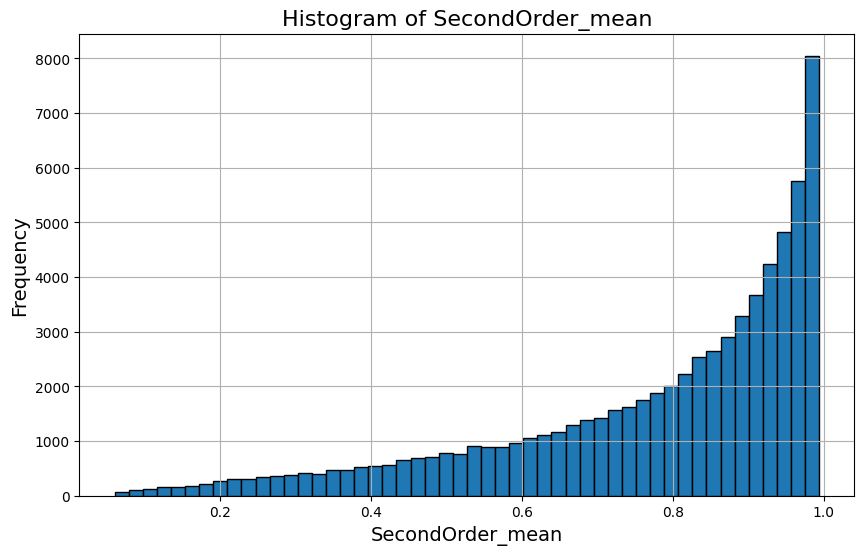

In [8]:
# Extraer todos los valores de secondOrder_mean_cor sin importar el theta
all_second_order_mean = secondOrder_mean_cor.flatten()

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(all_second_order_mean, bins=50, edgecolor='black')
plt.xlabel('SecondOrder_mean', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of SecondOrder_mean', fontsize=16)
plt.grid(True)
plt.show()